# 决策树 Decision Tree
## 特性：
1. 决策树将特征空间进行递归分割，每次总是验证特征变量的某个分量进行切割，从而得到”矩形“或者”超矩形“。

## 优点：
1. 决策树在进行节点分裂时，以节点不纯度下降幅度为依据，选择分裂变量，故考虑了y的信息，不受噪声变量的影响，适用于高维数据（剔除不重要变量）。
2. 决策树为非参数方法，不对函数形式作任何假设，比较稳健，其预测效果在某些情形下可能优于参数方法，如判别分析、逻辑回归。
3. 只要决策树不过于枝繁叶茂，其解释性很强。

## 缺点：
1. 如果决策边界的形状与”超矩形“相差较大，则可能导致较大误差。
2. 如果真实模型或者决策边界为线性，则线性模型的预测效果更好。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier,export_text,plot_tree
from sklearn.datasets import load_boston
from sklearn.metrics import cohen_kappa_score,confusion_matrix,classification_report,plot_roc_curve

# 一、回归树
1. 决策树用于回归问题，则称为回归树。
2. 回归树在进行预测时，预测值即为该叶子节点所有训练集的平均值。
3. 回归树的分裂准则较简单，可使用“最小化残差平方和”作为分裂指标，即节点分裂后，所产生的两个子节点的残差平方和之总和最小。
4. 变量重要性指，在回归树的所有节点，由于此变量所导致的$SSR$的总下降幅度。
5. 回归树需对目标函数引入惩罚项，减少最大纵深，即“修枝”。目标函数为：
$$\underset{T}{min}\quad\sum_{m=1}^{|T|}\sum_{x_i\in{R_m}}(y_i-\hat y_{R_m})^2+\lambda·|T|$$
6. 回归树的不纯度就是均方误差。

## 1、数据处理 

In [2]:
data=load_boston()
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## 2、建立回归树

In [3]:
xtrain,xtest,ytrain,ytest=train_test_split(data.data,data.target,test_size=0.3,random_state=0)
model=DecisionTreeRegressor(max_depth=2,random_state=123)
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.622596538377147

## 3、显示回归树（文本+图）

In [4]:
print(export_text(model,feature_names=list(data.feature_names)))#feature_names必须是list or str

|--- RM <= 6.80
|   |--- LSTAT <= 14.40
|   |   |--- value: [22.98]
|   |--- LSTAT >  14.40
|   |   |--- value: [14.81]
|--- RM >  6.80
|   |--- RM <= 7.43
|   |   |--- value: [30.92]
|   |--- RM >  7.43
|   |   |--- value: [44.71]



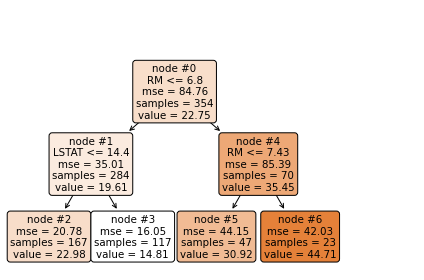

In [5]:
plot_tree(model,feature_names=data.feature_names,node_ids=True,rounded=True,precision=2,filled=True)
plt.tight_layout()

## 4、成本复杂性参数与不纯度

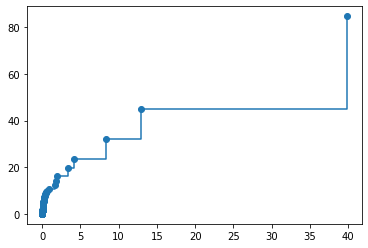

In [6]:
model=DecisionTreeRegressor(random_state=123)#必须重新实例化，因为选择ccp时不能指定树的最大纵深
path=model.cost_complexity_pruning_path(xtrain,ytrain)
plt.plot(path['ccp_alphas'],path['impurities'],marker='o',drawstyle='steps-post')#steps-post表示以阶梯形的方式画折线图


当ccp为0时，不惩罚决策树的规模，可能导致过拟合（枝繁叶茂）；当ccp太大时，对决策树规模的惩罚过于严厉，仅剩下树桩，导致MSE过大和过拟合。
## 5、考察最优CCP

In [7]:
param_grid={'ccp_alpha':path.ccp_alphas}
kfold=KFold(n_splits=10,shuffle=True,random_state=1)
model=GridSearchCV(DecisionTreeRegressor(random_state=123),param_grid,cv=kfold)
model.fit(xtrain,ytrain)
print(model.best_params_)
model=model.best_estimator_#实例model在拟合之后已经具备最优参数，但考虑到下文plot_tree函数不接受GridSearchCV对象作为估计量，故在此进行转换。
model.score(xtest,ytest)

{'ccp_alpha': 0.03671186440677543}


0.6705389109763318

In [8]:
from sklearn.linear_model import LinearRegression
r2=LinearRegression().fit(xtrain,ytrain).score(xtest,ytest)
r2

0.6733825506400184

线性回归在测试集的拟合优度高于最优回归树的拟合优度。

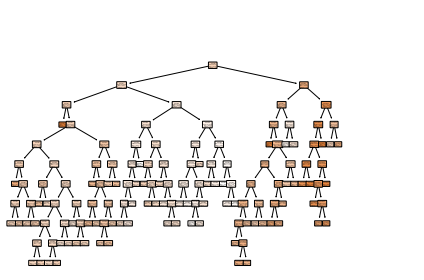

In [9]:
plot_tree(model,feature_names=data.feature_names,node_ids=True,filled=True,rounded=True)
plt.tight_layout()#防止出现大段的无关字符

In [10]:
model.get_depth(),model.get_n_leaves()

(10, 71)

## 6、考察变量重要性
变量重要性的度量：在回归树的所有节点，由于此变量所导致的$SSR$的总下降幅度。

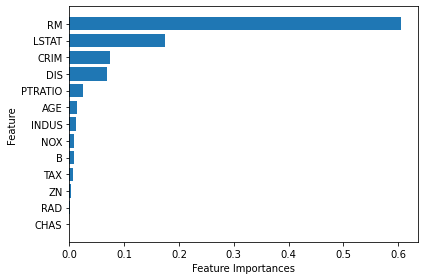

In [11]:
X=pd.DataFrame(data.data,columns=data.feature_names)
index=model.feature_importances_.argsort()
plt.barh(np.arange(X.shape[1]),model.feature_importances_[index])
plt.yticks(np.arange(X.shape[1]),labels=data.feature_names[index])
plt.xlabel('Feature Importances')
plt.ylabel('Feature')
plt.tight_layout()

## 7、预测效果

Text(0.5, 1.0, 'Tree Prediction')

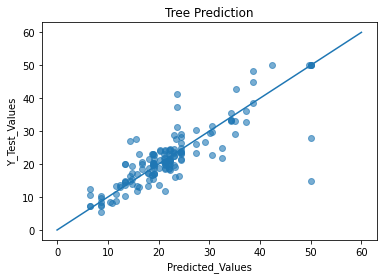

In [12]:
pred=model.predict(xtest)
plt.scatter(pred,ytest,alpha=0.6)#alpha表示透明度
w=np.linspace(0,60,100)
plt.plot(w,w)
plt.xlabel('Predicted_Values')
plt.ylabel('Y_Test_Values')
plt.title('Tree Prediction')

# 二、分类树
1. 决策树用于分类问题，则称为分类树。
2. 分类树在进行预测时，遵循多数票原则，预测值即为该叶子节点所有训练集中最常见的类别。
3. 分类树的分裂准则（节点不纯度函数）较复杂，可使用错分率、基尼指数、信息熵等作为分裂指标，即选择使节点不纯度函数下降最多的变量作为分裂变量。
   - 错分率$$Err(p_1,\cdots,p_k)=1-max\lbrace p_1,\cdots,p_k\rbrace$$
   - 基尼指数$$Gini(p_1,\cdots,p_k)=\sum_{k=1}^{K}p_k(1-p_k)=1-\sum_{k=1}^K{p_k}^2$$对于二分类问题，基尼指数可以写为$$Gini(p_1,p_2)=2p_1(1-p_1)$$故在多分类情况下，基尼指数可解释为单独取出其中某类，将其他类归并一类，计算此两点分布的方差，然后重复此过程，将所有方差加总。即$\sum_{k=1}^{K}p_k(1-p_k)$
   - 信息熵（期望信息量）$$Entropy(p_1,\cdots,p_k)=E(\log_2{\frac{1}{p_k}})$$
4. 变量重要性指，在分类树的所有节点，由于此变量所导致的节点不纯度函数的总下降幅度。
5. 分类树需对目标函数引入惩罚项，减少最大纵深，即“修枝”。目标函数为：$$\underset{T}{min}\quad \underbrace{R(T)}_{cost}+\lambda \underbrace{|T|}_{complexity}$$ $|T|$表示叶子节点数目。若损失函数$R(T)$为0-1损失函数，则成本复杂性修枝为：$$\underset{T}{min}\quad \underbrace{\sum_{m=1}^{|T|}\sum_{x_i\in R_m}{(y_i\neq \hat y_{R_m})}}_{cost}+\lambda\underbrace{|T|}_{complexity}$$

## 1、数据处理

In [13]:
data=pd.read_csv('/Users/singal/Desktop/MLPython_Data/bank-additional.csv',sep=';')

In [14]:
data.shape

(4119, 21)

In [15]:
pd.options.display.max_columns=30
data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [16]:
data=data.drop('duration',axis=1)#此变量无意义

In [17]:
data.y.value_counts(),data.y.value_counts(normalize=True)

(no     3668
 yes     451
 Name: y, dtype: int64,
 no     0.890507
 yes    0.109493
 Name: y, dtype: float64)

In [18]:
data.groupby('y').mean()#类别不平衡的数据集，故尝试查看分组平均值

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,
no,39.895311,2.605780,982.763086,0.141767,0.240185,93.599677,-40.586723,3.802826,5175.502072
yes,41.889135,1.980044,778.722838,0.585366,-1.177384,93.417268,-39.786475,2.145448,5093.118625


In [19]:
X=data.iloc[:,:-1]
X=pd.get_dummies(X)#生成虚拟变量

In [20]:
y=data.iloc[:,-1]

## 2、建立分类树

In [21]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,stratify=y,test_size=1000,random_state=1)#传递了stratify参数，就无需传递shuffle参数
model=DecisionTreeClassifier(max_depth=2,random_state=123)#与回归树类一样，ccp默认为0，故需指定最大纵深，防止过拟合
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.904

## 3、显示分类树（文本+图）

In [22]:
print(export_text(model,feature_names=list(X.columns)))

|--- nr.employed <= 5087.65
|   |--- pdays <= 12.50
|   |   |--- class: yes
|   |--- pdays >  12.50
|   |   |--- class: no
|--- nr.employed >  5087.65
|   |--- month_mar <= 0.50
|   |   |--- class: no
|   |--- month_mar >  0.50
|   |   |--- class: no



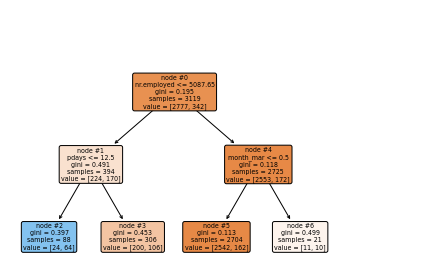

In [23]:
plot_tree(model,node_ids=True,filled=True,rounded=True,feature_names=X.columns)
plt.tight_layout()

## 4、成本复杂性参数与不纯度

Text(0, 0.5, 'Total Leaf Impurities')

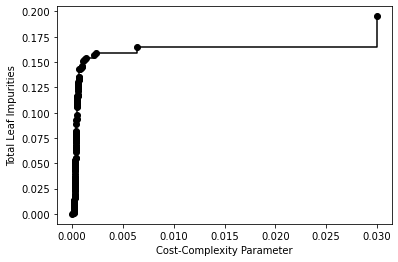

In [24]:
ccp_path=DecisionTreeClassifier(random_state=123).cost_complexity_pruning_path(xtrain,ytrain)
plt.plot(ccp_path.ccp_alphas,ccp_path.impurities,marker='o',drawstyle='steps-post',c='k')
plt.xlabel('Cost-Complexity Parameter')
plt.ylabel('Total Leaf Impurities')

## 5、考察CCP

In [25]:
param_grid={'ccp_alpha':ccp_path.ccp_alphas}
kfold=StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
model=GridSearchCV(DecisionTreeClassifier(random_state=123),param_grid=param_grid,cv=kfold)
model.fit(xtrain,ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'ccp_alpha': array([0.        , 0.0001275 , 0.00015784, 0.00015931, 0.00018321,
       0.00020038, 0.00020306, 0.00020403, 0.00020484, 0.00020519,
       0.00020662, 0.00020706, 0.00020786, 0.00020865, 0.00021158,
       0.00021163, 0.00021374, 0.00021374, 0.0002...
       0.00048092, 0.00048092, 0.00049874, 0.0005077 , 0.00051298,
       0.00051298, 0.00053043, 0.00053436, 0.00053436, 0.00055396,
       0.00055872, 0.00056052, 0.00056998, 0.0005709 , 0.00057711,
       0.00057842, 0.00060854, 0.00061694, 0.00062833, 0.00062957,
       0.00063529, 0.00064863, 0.00067707, 0.00071935, 0.00079946,
       0.00086934, 0.00095337, 0.00098565, 0.0010825 , 0.00113888,
       0.00122645, 0.0013991 , 0.00215108, 0.00231549, 0.00635727,
       0.02994953])})

In [26]:
model.best_params_,model.best_score_#表示Mean cross-validated score of the best_estimator

({'ccp_alpha': 0.0021510777681259807}, 0.9012521642344794)

In [27]:
model.score(xtrain,ytrain),model.score(xtest,ytest)

(0.903174094260981, 0.904)

In [28]:
model=model.best_estimator_

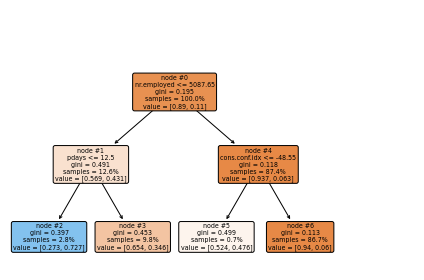

In [29]:
plot_tree(model,node_ids=True,rounded=True,feature_names=X.columns,filled=True,proportion=True)
plt.tight_layout()

结果显示，对于最左边的叶子节点node#2，可预测为“有购买意愿"，故只需给$$nr.employed<=5087.85\quad\bigcap\quad pdays<=12.5$$这类客户致电即可。当然，对于node#3和node#5，也是潜在的可致电客户。
## 6、考察变量重要性

In [30]:
model.feature_importances_

array([0.        , 0.        , 0.16460096, 0.        , 0.        ,
       0.        , 0.05995227, 0.        , 0.77544677, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

结果显示，只有三个变量的重要程度为正，即只有选择这三个变量作为分裂变量才能使得总分类节点的基尼系数下降。

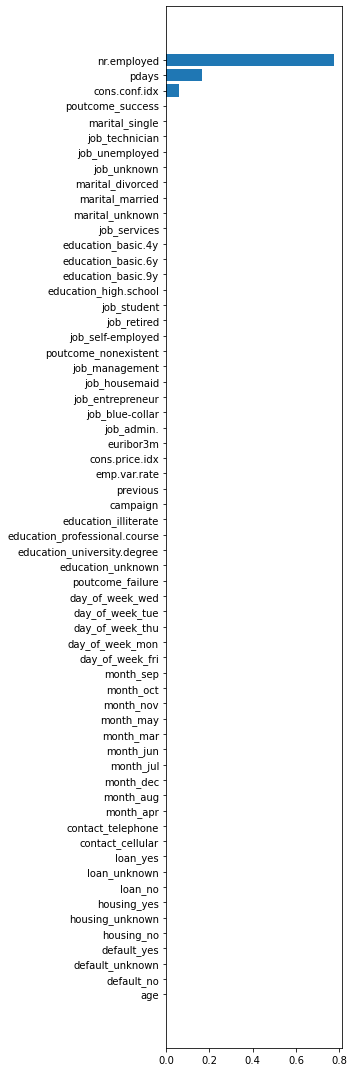

In [31]:
index=np.argsort(model.feature_importances_)
plt.figure(figsize=(5,15))
plt.barh(range(X.shape[1]),model.feature_importances_[index])#width必须是从小到大排序，才能得到理想效果，这是因为barh函数默认将width参数从下往上画
plt.yticks(range(X.shape[1]),labels=X.columns[index])
plt.tight_layout()

## 7、分类树评价

In [32]:
pred=model.predict(xtest)
matrix=pd.crosstab(ytest,pred,rownames=['Actual'],colnames=['Predicted'])
matrix

Predicted,no,yes
Actual,,
no,880,11
yes,85,24


In [33]:
matrix=np.array(matrix)
accuracy=(matrix[0,0]+matrix[1,1])/matrix.sum()
sensitivity=matrix[1,1]/(matrix[1,0]+matrix[1,1])
print('准确率为：',accuracy)
print('灵敏度为：',sensitivity)

准确率为： 0.904
灵敏度为： 0.22018348623853212


虽然算法的准确率高达90.4%，但灵敏度只有22%，事实上，由于该样本中无购买意向的客户占比高达89.1%，故只要全部预测为”无购买意向“，准确率也能达到89.1%，故90.4%的准确率，意义不大。

In [34]:
cohen_kappa_score(ytest,pred)

0.2960328518002493

科恩的kappa指标仅为0.296，处于0.2至0.4的区间，即预测值与实际值的一致性一般。但这并不表明此决策树算法无意义，事实上，只需将客户有购买意向的概率门槛值从默认0.5降低，即可提高灵敏度。

In [35]:
prob=model.predict_proba(xtest)
model.classes_,prob

(array(['no', 'yes'], dtype=object),
 array([[0.94008876, 0.05991124],
        [0.94008876, 0.05991124],
        [0.94008876, 0.05991124],
        ...,
        [0.94008876, 0.05991124],
        [0.94008876, 0.05991124],
        [0.94008876, 0.05991124]]))

In [36]:
pred_new=prob[:,1]>=0.1#门槛降至0.1
matrix=pd.crosstab(ytest,pred_new,colnames=['Predicted'],rownames=['Actual'])
matrix

Predicted,False,True
Actual,,
no,821,70
yes,50,59


In [37]:
matrix=np.array(matrix)
accuracy=(matrix[0,0]+matrix[1,1])/matrix.sum()
sensitivity=matrix[1,1]/(matrix[1,:]).sum()
print('准确率为：',accuracy)
print('灵敏度为：',sensitivity)

准确率为： 0.88
灵敏度为： 0.5412844036697247


结果显示，将预测概率门槛从0.5降至0.1后，灵敏度明显改善，决策树算法可识别54.1%的有购买意向的客户。

## 8、以信息熵information entropy作为分裂准则criterion

In [38]:
model=GridSearchCV(DecisionTreeClassifier(criterion='entropy',random_state=123),param_grid=param_grid,cv=kfold)
model.fit(xtrain,ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=123),
             param_grid={'ccp_alpha': array([0.        , 0.0001275 , 0.00015784, 0.00015931, 0.00018321,
       0.00020038, 0.00020306, 0.00020403, 0.00020484, 0.00020519,
       0.00020662, 0.00020706, 0.00020786, 0.00020865, 0.00021158,
       0.00021163, 0.000213...
       0.00048092, 0.00048092, 0.00049874, 0.0005077 , 0.00051298,
       0.00051298, 0.00053043, 0.00053436, 0.00053436, 0.00055396,
       0.00055872, 0.00056052, 0.00056998, 0.0005709 , 0.00057711,
       0.00057842, 0.00060854, 0.00061694, 0.00062833, 0.00062957,
       0.00063529, 0.00064863, 0.00067707, 0.00071935, 0.00079946,
       0.00086934, 0.00095337, 0.00098565, 0.0010825 , 0.00113888,
       0.00122645, 0.0013991 , 0.00215108, 0.00231549, 0.00635727,
       0.02994953])})

In [39]:
print('信息熵所得的预测准确率：',model.score(xtrain,ytrain))
matrix=pd.crosstab(ytest,model.predict(xtest),rownames=['Actual'],colnames=['Predicted'])
matrix

信息熵所得的预测准确率： 0.903174094260981


Predicted,no,yes
Actual,,
no,880,11
yes,85,24


结果表明，无论使用信息熵还是基尼指数作为分裂准则，测试集的混淆矩阵一模一样。
## 9、决策边界

In [40]:
from sklearn.datasets import load_iris
X,y=load_iris(return_X_y=True)
X=X[:,2:4]
model=DecisionTreeClassifier(random_state=123)
ccp_path=model.cost_complexity_pruning_path(X,y)
param_grid={'ccp_alpha':ccp_path.ccp_alphas}
kfold=StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
model=GridSearchCV(DecisionTreeClassifier(random_state=123),param_grid=param_grid,cv=kfold)
model.fit(X,y)
model.score(X,y)

0.9933333333333333

<AxesSubplot:>

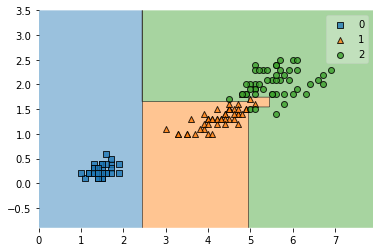

In [42]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X,y,model)